# Machine Learning Model: Multivariate linear regression

In [1]:
from __future__ import division

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from scipy import linalg
from sklearn.linear_model import LinearRegression

In [3]:
%matplotlib inline

In [4]:
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("talk")

# 2 Linear regression with multiple variables

Load the dataset.

In [5]:
data = np.loadtxt('data/dataset2.txt', delimiter=',')

In [6]:
x0 = data[:, 0]
x1 = data[:, 1]
y = data[:, -1]

M = len(y)

Visualize 2D projections of the data.

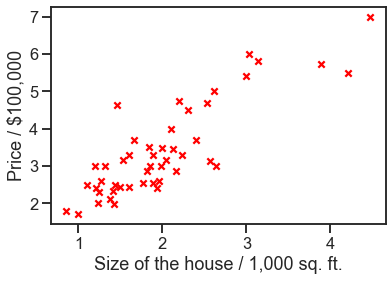

In [7]:
plt.figure()
plt.scatter(x0 / 1e3, y / 1e5, c='r', marker='x', s=40)
plt.xlabel('Size of the house / 1,000 sq. ft.')
plt.ylabel('Price / $100,000')
plt.savefig('multivariate_plots/price_vs_sq_feet.png', dpi=300)

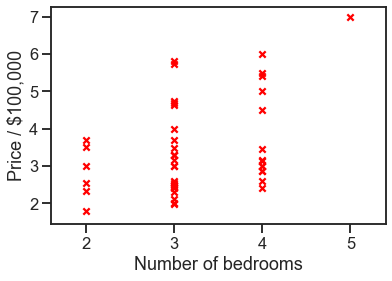

In [8]:
plt.figure()
plt.scatter(x1, y / 1e5, c='r', marker='x', s=40)
plt.xlabel('Number of bedrooms')
plt.ylabel('Price / $100,000')
plt.xlim(1.6, 5.4)
plt.xticks([2, 3, 4, 5])
plt.savefig('multivariate_plots/price_vs_num_bedrooms.png', dpi=300)

Visualizating the data with a seaborn plot.  This is an adaption of an example in the seaborn gallery (https://stanford.edu/~mwaskom/software/seaborn/examples/pair_grid_with_kde.html).

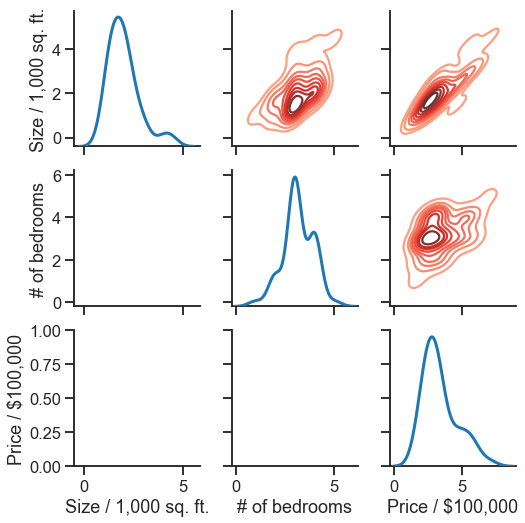

In [9]:
df = pd.DataFrame(np.vstack((x0 / 1e3, x1, y / 1e5)).T, 
    columns=['Size / 1,000 sq. ft.', '# of bedrooms', 'Price / $100,000'])

g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.kdeplot, cmap="Reds_d")
g.map_lower(plt.scatter)
g.map_diag(sns.kdeplot, lw=3);

## 2.1 Feature normalization

Add a column of ones to the data matrix that allows us to treat the intercept parameter as a feature.

In [10]:
X = np.vstack((np.ones(M), x0, x1)).T

Define a function returning the normalized data matrix as well as feature means and standard deviations.

In [11]:
def feature_normalize(X):
    """
    Normalize features for reshaping data. Normalizes all the features from the
    training set and set them to a comparable range, so that none of the features can
    dominate over the prediction all by itself.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1), where m is the number of examples,
        and n is the number of features. We assume a vector of one's already 
        appended to the features so we have n+1 columns.
    
    Returns
    -------
    X_norm_T.T : transpose matrix of the X norm

    mu: Mean for the transpose matrix

    sigma: Standard deviation for the transpose matrix
    """
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    
    X_norm_T = np.ones_like(X.T)
    for i, feature in enumerate(X.T):
        if i == 0: continue # skip normalization of the column of ones in X 
        X_norm_T[i] = (feature - mu[i]) / sigma[i]
        
    return X_norm_T.T, mu, sigma

Normalize the features.

In [12]:
X_norm, mu, sigma = feature_normalize(X)

## 2.2 Gradient descent

Initialize each of the three model parameters to zero. 

In [13]:
theta_0 = np.zeros(3)

Define the cost function for multivariate regression.  (It ends up being the same function as for the univariate case due to vectorization.)

In [14]:
def compute_cost(X, y, M, theta):
    """
    Compute cost for linear regression. Computes the cost of using theta as the
    parameter for linear regression to fit the data points in X and y.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1), where m is the number of examples,
        and n is the number of features. We assume a vector of one's already 
        appended to the features so we have n+1 columns.
    
    y : array_like
        The values of the function at each data point. This is a vector of
        shape (m, ).
    
    theta : array_like
        The parameters for the regression function. This is a vector of 
        shape (n+1, ).
    
    Returns
    -------
    J : float
        The value of the regression cost function.
    """
    return 1 / 2 / M  * np.sum((theta.dot(X.T) - y)**2)

Test it.

In [15]:
print( 'Initial cost: %.3e' % compute_cost(X_norm, y, M, theta_0))

Initial cost: 6.559e+10


Define hyperparameters for batch gradient descent.

In [16]:
num_iters = 1000
alpha = 0.1

Implement the gradient descent algorithm. (Again, it ends up being the same function as for the univariate case.)

In [17]:
def gradient_descent(X, y, M, theta_0, alpha, num_iters):
    """
    Performs gradient descent to learn `theta`. Updates theta by taking `num_iters`
    gradient steps with learning rate `alpha`.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1).
    
    y : arra_like
        Value at given features. A vector of shape (m, ).
    
    theta : array_like
        Initial values for the linear regression parameters. 
        A vector of shape (n+1, ).
    
    alpha : float
        The learning rate.
    
    num_iters : int
        The number of iterations for gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1, ).
    
    J_history : list
        A python list for the values of the cost function after each iteration.
    """
    J_history = np.zeros(num_iters)
    theta = theta_0.copy()
    for i in range(num_iters):
        J_history[i] = compute_cost(X, y, M, theta)
        theta -= alpha / M * (theta.dot(X.T) - y).dot(X)
        
    return theta, J_history

Test it.

In [18]:
theta, J_history = gradient_descent(X_norm, y, M, theta_0, alpha, num_iters)

In [19]:
print('Theta found by gradient descent:', ', '.join('%.3f' % item for item in theta))

Theta found by gradient descent: 340412.660, 110631.050, -6649.474


## 2.3 Plot cost vs. steps.

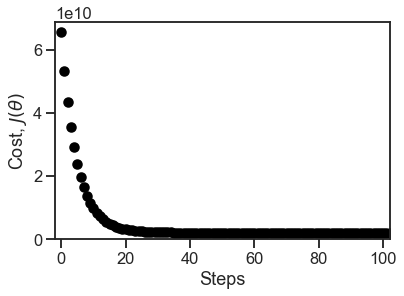

In [20]:
plt.figure()
plt.scatter(np.arange(num_iters), J_history, c='k', marker='o')
plt.xlabel('Steps')
plt.ylabel('Cost, ' + r'$J(\theta)$')
plt.xlim(-num_iters / 10 * 0.02, num_iters / 10 * 1.02)
plt.ylim(0, max(J_history) * 1.05)
plt.savefig('multivariate_plots/cost_vs_steps.png', dpi=300)

Plot cost vs. steps for multiple choices of the learning rate, alpha.

In [21]:
_, J_history_1 = gradient_descent(X_norm, y, M, theta_0, 0.01, num_iters)
_, J_history_2 = gradient_descent(X_norm, y, M, theta_0, 0.03, num_iters)
_, J_history_3 = gradient_descent(X_norm, y, M, theta_0, 0.30, num_iters)

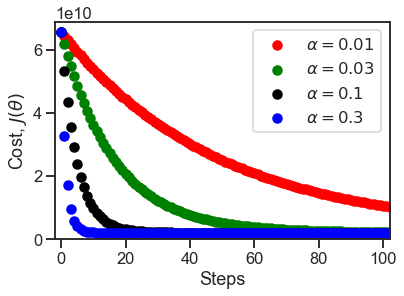

In [22]:
plt.figure()
plt.scatter(np.arange(num_iters), J_history_1, c='r', marker='o', label=r'$\alpha=0.01$')
plt.scatter(np.arange(num_iters), J_history_2, c='g', marker='o', label=r'$\alpha=0.03$')
plt.scatter(np.arange(num_iters), J_history, c='k', marker='o', label=r'$\alpha=0.1$')
plt.scatter(np.arange(num_iters), J_history_3, c='b', marker='o', label=r'$\alpha=0.3$')
plt.xlabel('Steps')
plt.ylabel('Cost, ' + r'$J(\theta)$')
plt.xlim(-num_iters / 10 * 0.02, num_iters / 10 * 1.02)
plt.ylim(0, max(J_history) * 1.05)
plt.legend(numpoints=1, loc=0)
plt.savefig('multivariate_plots/cost_vs_steps_varying_alpha.png', dpi=300)

Define a function that returns the model prediction for price.

In [23]:
def prediction(theta, x0, x1, mu, sigma):
    return theta[0] + (x0 - mu[1]) / sigma[1] * theta[1] + (x1 - mu[2]) / sigma[2] * theta[2]

Compare training data with linear regression predictions.

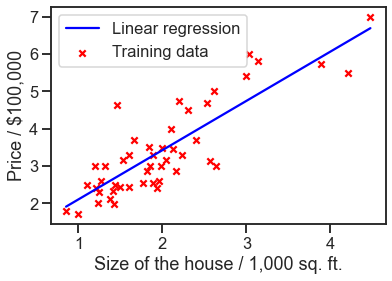

In [24]:
ps = prediction(theta, x0, x1, mu, sigma)
ps_min_index = ps.argmin()
ps_max_index = ps.argmax()
sq_feet_pts = np.array([x0[ps_min_index], x0[ps_max_index]])
price_pts = np.array([ps[ps_min_index], ps[ps_max_index]])

plt.figure()
plt.scatter(x0 / 1e3, y / 1e5, c='r', marker='x', s=40, label='Training data')
plt.plot(sq_feet_pts / 1e3, price_pts / 1e5, c='b', label='Linear regression')
plt.xlabel('Size of the house / 1,000 sq. ft.')
plt.ylabel('Price / $100,000')
plt.legend(numpoints=1, loc=2)
plt.savefig('multivariate_plots/price_vs_sq_feet_fit.png', dpi=300)

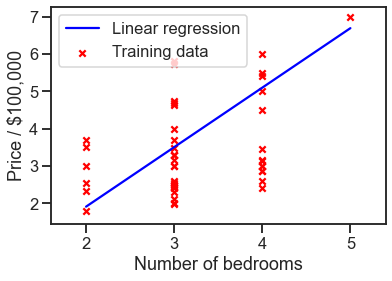

In [25]:
num_bedroom_pts = np.array([x1[ps_min_index], x1[ps_max_index]])
price_pts = np.array([ps[ps_min_index], ps[ps_max_index]])

plt.figure()
plt.scatter(x1, y / 1e5, c='r', marker='x', s=40, label='Training data')
plt.plot(num_bedroom_pts, price_pts / 1e5, c='b', label='Linear regression')
plt.xlabel('Number of bedrooms')
plt.ylabel('Price / $100,000')
plt.xlim(1.6, 5.4)
plt.xticks([2, 3, 4, 5])
plt.legend(numpoints=1, loc=2)
plt.savefig('multivariate_plots/price_vs_num_bedrooms_fit.png', dpi=300)

## 3.3 Normal equations

Define a function to compute the analytical solution to linear regression.

In [26]:
def normal_eqn(X, y):
    """
    Computes the normal equations from input and output values. Computes 
    the closed-form solution to linear regression using the normal equations.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n+1).
    
    y : arra_like
        Value at given features. A vector of shape (m, ).
    
    Returns
    -------
    a matrix formed by the input and output values as a normal equation matrix.
    """
    return linalg.inv(X.T.dot(X)).dot(X.T).dot(y).T

Test it.

In [27]:
theta_from_normal_eqn = normal_eqn(X_norm, y)

In [28]:
print('Best fit parameters obtained from gradient descent:', \
    ', '.join('%.3f' % item for item in theta))
print('Best fit parameters obtained from the normal equations:', \
    ', '.join('%.3f' % item for item in theta_from_normal_eqn))

Best fit parameters obtained from gradient descent: 340412.660, 110631.050, -6649.474
Best fit parameters obtained from the normal equations: 340412.660, 110631.050, -6649.474


In [29]:
square_feet = 1650
num_bedrooms = 3
print('For a %d-square-foot house with %d bedrooms, the price predicted by the model trained using:' \
    % (square_feet, num_bedrooms))
print('\t gradient decent is $%0.2f.' \
    % prediction(theta, square_feet, num_bedrooms, mu, sigma))
print('\t the normal equations is $%0.2f.' \
    % prediction(theta_from_normal_eqn, square_feet, num_bedrooms, mu, sigma))

For a 1650-square-foot house with 3 bedrooms, the price predicted by the model trained using:
	 gradient decent is $293081.46.
	 the normal equations is $293081.46.


# Linear regression with scikit-learn.

The data matrix, X, should have dimensions ```num_samples x num_features``` and should omit the initial column of ones.

In [30]:
clf = LinearRegression() 
clf.fit(X_norm[:, 1:], y) 
theta_sklearn = np.array([clf.intercept_, clf.coef_[0], clf.coef_[1]])

In [31]:
print('Best fit parameters obtained from gradient descent:', \
    ', '.join('%.3f' % item for item in theta))
print('Best fit parameters obtained from the normal equations:', \
    ', '.join('%.3f' % item for item in theta_sklearn))

Best fit parameters obtained from gradient descent: 340412.660, 110631.050, -6649.474
Best fit parameters obtained from the normal equations: 340412.660, 110631.050, -6649.474


In [32]:
square_feet = 1650
num_bedrooms = 3
print('For a %d-square-foot house with %d bedrooms, the price predicted by the model trained using:' \
    % (square_feet, num_bedrooms))
print('\t gradient decent is $%0.2f.' \
    % prediction(theta, square_feet, num_bedrooms, mu, sigma))
print('\t the normal equations is $%0.2f.' \
    % prediction(theta_sklearn, square_feet, num_bedrooms, mu, sigma))

For a 1650-square-foot house with 3 bedrooms, the price predicted by the model trained using:
	 gradient decent is $293081.46.
	 the normal equations is $293081.46.
